## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import math
import os
%matplotlib inline

### Camera Calibration Helper Functions

In [2]:
def find_corners(gray_img, nx, ny):
    """Find corners on a chessboard for camera calibration"""
    return cv2.findChessboardCorners(gray_img, (nx, ny), None)

def draw_corners(img, nx, ny, corners, ret):
    """Draws chessboard corners"""
    return cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

def calibrate(objpoints, imgpoints, img_shape):
    """Calibrates camera"""
    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [3]:
def get_calibration_points():
    """
    Gets object points and image points for camera calibration
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    
    # plot counter
    counter = 0
    
    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    for fname in images:
        
        #read in each img
        # note!!! cv2.imread reads in image as BGR
        img = cv2.imread(fname)
        
        # image shape
        img_size = img.shape[1::-1]
        
        #convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # find corners
        ret, corners = find_corners(gray, nx, ny)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # draw and display the corners
            img = draw_corners(img, nx, ny, corners, ret)
            
            # source points
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            
            offset = 100
            
            # destination points
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
            
            # Compute the perspective transform, M, given
            # source and destination points
            M = cv2.getPerspectiveTransform(src, dst)
            
            # Warp an image using the perspective transform, M:
            warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
            if counter < 1:
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                ax1.set_title('Original', size=30)
                ax1.imshow(img)
                ax2.set_title('Undistorted & Transformed', size=30)
                ax2.imshow(warped)
                
                counter += 1
            
    return objpoints, imgpoints, img_size, corners

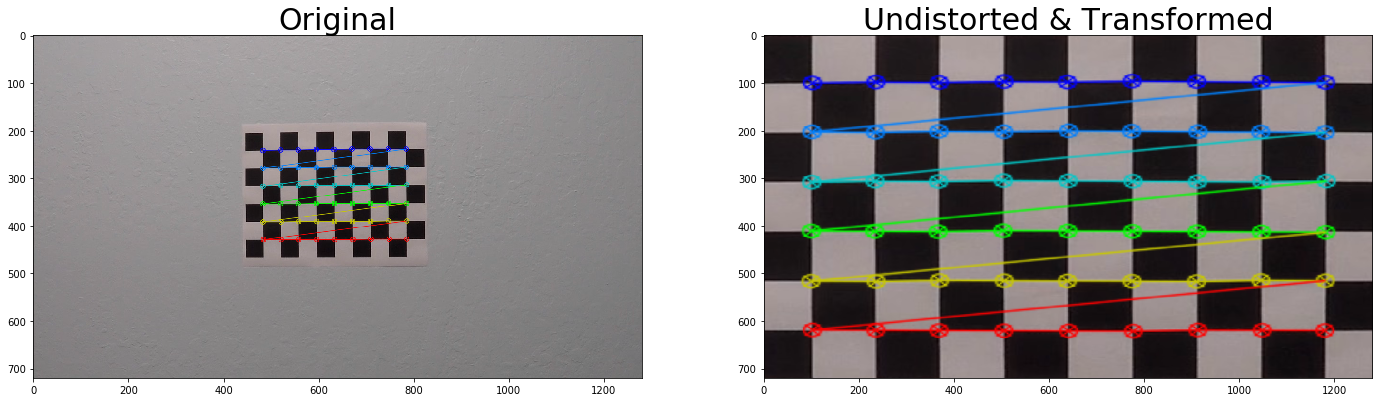

In [4]:
# gets calibration points for camera calibration
objpoints, imgpoints, img_size, corners = get_calibration_points()

# only do this once
# calibrate camera
ret, mtx, dist, rvecs, tvecs = calibrate(objpoints, imgpoints, img_size)

### Lane Detection Helper Functions

In [5]:
def rgb_grayscale(img):
    """
    Applies the Grayscale transform
    Return: Grayscale img
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def undistort(img, mtx, dist):
    """
    Undistorts an image
    Return: Undistored img
    """
    return cv2.undistort(img, mtx, dist, None, mtx)


def cvt_to_hls(img):
    """
    Applies a RGB to HLS color transform
    Return: HLS img representation
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


def sobel_x(channel):
    """
    Takes derivative of x values
    """
    return cv2.Sobel(channel, cv2.CV_64F, 1, 0)


def scale_sobel(abs_sobel):
    """
    Absolute x derivative to accentuate lines away from horizontal.
    """
    return np.uint8(255*abs_sobel/np.max(abs_sobel))
    

def get_src(img_size):
    """Returns source points"""
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    return src


def get_dst(img_size):
    """Returns destination points"""
    # img width
    width = img_size[0]
    # img height
    height = img_size[1]
    
    # destination point for transformation
    dst = np.float32(
        [[(width / 4), 0],
         [(width / 4), height],
         [(width * 3 / 4), height],
         [(width * 3 / 4), 0]])

    return dst

### Combined Binary Image

In [6]:
def get_color_thresh(img):
    
    # Converts to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cvt_to_hls(img)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = rgb_grayscale(img)

    # Sobel x
    sobelx = sobel_x(gray) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = scale_sobel(abs_sobelx)

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # Returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary, color_binary

### Transform to Top View

In [7]:
def transform(binary_img):
    """
    Applies an image mask and transforms the image to a birds eye view.
    Return: Top/birds view of lane.
    """ 
    # image size (width, height)
    img_size = binary_img.shape[1::-1]
    
    # gets the bounding vertices for the mask (source points)
    src = get_src(img_size)
    
    # gets destination points
    dst = get_dst(img_size)
    
    # Compute the perspective transform, M, given
    # source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_NEAREST)

#     color = [255, 0, 0]
#     thickness = 4
#     cv2.line(warped, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), color, thickness)
#     cv2.line(warped, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), color, thickness)
#     cv2.line(warped, (dst[3][0], dst[3][1]), (dst[0][0], dst[0][1]), color, thickness)

    return warped

## Locate Lines


### Shifting Window

In [8]:
def locate_lines(binary_warped):
    """
    Locates the left and right lane line in a binary_warped image.
    """
    # Take a histogram of the bottom half of binary_warped image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Creates an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Finds the peak of the left and right halves of the histogram
    # These are the starting points for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9
    
    # Sets height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identifies the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # set/update left_fit, right_fit class attributes
    left_line.set_recent_poly_coef(left_fit)
    right_line.set_recent_poly_coef(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # set/update left_fitx, right_fitx class attributes
    left_line.set_recent_xfitted(left_fitx)
    right_line.set_recent_xfitted(right_fitx)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty

### Line Search Within Region

In [9]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Fits a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # set/update left_fit, right_fit class attributes
    left_line.set_recent_poly_coef(left_fit)
    right_line.set_recent_poly_coef(right_fit)
    
    # set/update left_fitx, right_fitx class attributes
    left_line.set_recent_xfitted(left_fitx)
    right_line.set_recent_xfitted(right_fitx)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped):
    """
    Searches for lane pixels within a margin of the previously
    detected lane lines.
    """
    # Width of the margin around the previous polynomial to search
    margin =100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # get average of n iterations of left_fit and right_fit
    left_fit = left_line.get_avg_poly_coef()
    right_fit = right_line.get_avg_poly_coef()
    
    # Sets the area of search based on activated x-values
    # within the +/- margin of our polynomial function.
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255, 242, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255, 242, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    # ax1.imshow(out_img)
    # Plot the polynomial lines onto the image
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    
    return result, ploty

### Calculate Line Curvature

In [10]:
def get_curvature(ploty, img_size):
    """Calculates the curvature of polynomial functions in meters."""
    
    left_fitx = left_line.recent_xfitted[-1]
    right_fitx = right_line.recent_xfitted[-1]
    
    # Conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # y-value where radius of curvature is calculated
    # Maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curve_radius = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_radius = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # update left and right curve radius
    left_line.set_radius_of_curvature(left_curve_radius)
    right_line.set_radius_of_curvature(right_curve_radius)
    
    left_fit = left_line.poly_coef[0]
    right_fit = right_line.poly_coef[0]
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # set lane center
    lines.set_lane_center(left_lane_bottom, right_lane_bottom)

    # get img midpoint/car position
    img_midpoint = img_size[0] / 2
    
    # set deviation in pixels and meters
    lines.set_deviation(img_midpoint, xm_per_pix)

### Draw Predicted Lines

In [11]:
def draw_lines(img, warped, ploty):
    
    # get the avg left_fitx, right_fitx from Line class
    left_fitx = left_line.get_avg_xfitted()
    right_fitx = right_line.get_avg_xfitted()
  
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (110, 0, 211))
    
    # image size
    img_size = img.shape[1::-1]
    
    # get the bounding vertices for the mask (source points)
    src = get_src(img_size)
    
    # get destination points
    dst = get_dst(img_size)
    
    # inverse perspective transform
    M = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, img_size) 
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.5, 0)

### Combine Visual Results

In [12]:
def merge_outputs(binary_img, color_img, output_img, result):
    """Merges multiple visuals into one output image"""
    
    # img width
    width = result.shape[1]
    # img height
    height = result.shape[0]
    # img midpoint
    midpoint = int(width / 2)
    
    img = np.zeros_like(result)

    # resize images
    color_img = cv2.resize(color_img, (0,0), fx=0.5, fy=0.5)
    output_img = cv2.resize(output_img, (0,0), fx=0.5, fy=0.5)
    
    # concat resized images vertically
    vert = np.concatenate((output_img, color_img), axis=0)
    result = np.concatenate((result, vert), axis=1)
    
    # draw and fill rectangle for lane line info
    cv2.rectangle(result, (0, 0), (460, 100),(0, 0, 0), -1)
    
    # Display text info of left lane radius
    cv2.putText(result, "Corner Radius: {} km".format(round(lines.get_radius_of_curvature()/1000, 1)),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 228, 0), 3)

    # get car deviation from center in meters
    m_from_center = lines.dist_from_center_m
    # get car deviation from center in pixels
    px_from_center = lines.dist_from_center_px
    
    # lane_center = lines.lane_center
    # cv2.line(result, (int(lane_center), height - 120), (int(lane_center), height - 70), (0, 228, 0), 4)
    
    # draw lane center
    # cv2.line(result, (int(midpoint - (px_from_center/2)), height - 110), (int(midpoint - (px_from_center/2)), height - 80), (0, 228, 0), 5)
    
    # draw current car position
    # cv2.line(result, (int(midpoint), height - 110), (int(midpoint), height - 80), (0, 228, 0), 5)
    
    if m_from_center > 0:
        direction = 'left'
    else:
        direction = 'right'
    
    # display text for car position
    cv2.putText(result, "Deviation: {:.2f}m {}".format(np.absolute(m_from_center), direction),
                (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 228, 0), 3)
    
    return result

## Pipeline

In [13]:
def pipeline(img):

    # undistort image
    undist = undistort(img, mtx, dist)
    
    # create copy of undistorted image
    img = np.copy(undist)
    
    # img size
    img_size = img.shape[1::-1]
    
    # get gradient thresholds
    binary_image, color_img = get_color_thresh(undist)
    
    # transform img to arial view
    warped = transform(binary_image)
    

    if not lines.detected:
        
        # Locate lane lines
        output_img, ploty = locate_lines(warped)
        
        # draw lines on located lines
        result = draw_lines(img, warped, ploty)
        
        # Window method has found ane lines, set detected to true
        lines.set_detected(True)
        
    else:
        # Locate lane lines within small region
        output_img, ploty = search_around_poly(warped)
        
        # draw lines on located lines
        result = draw_lines(img, warped, ploty)
        
    
    # Calculate lane curvature
    get_curvature(ploty, img_size)
    
    # combine visual results
    final = merge_outputs(binary_image, color_img, output_img, result)
    
#     To visualize output for test images, uncomment
#     f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
#     ax1.imshow(final)
    
    return final

### Test Images

In [14]:
# Class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        
        #polynomial coefficients for the most recent fit
        self.poly_coef = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        # center of lane
        self.lane_center = None
        
        #distance in meters of vehicle center from the line
        self.dist_from_center_m = None
        
        #distance in pixels of vehicle center from the line
        self.dist_from_center_px = None


    def set_detected(self, boolean):
        """Were lane lines located using window method."""
        self.detected = boolean
    
    def set_recent_xfitted(self, xfitted):
        """
        Stores x values of the last 5 fits of the line
        param: left_fitx, right_fitx
        """
        self.recent_xfitted.append(xfitted)
        
        if len(self.recent_xfitted) > 5:
            self.recent_xfitted.pop(0)
        
    def get_avg_xfitted(self):
        """
        Returns the average x values of the fitted line over the
        last 5 iterations.
        Return: avg of self.recent_xfitted
        """
        return np.average(self.recent_xfitted, axis=0)
        
    def set_recent_poly_coef(self, fit):
        """
        Stores polynomial coefficients over the last 
        5 iterations.
        Params: left_fit or right_fit"""
        self.poly_coef.append(fit)
        
        if len(self.poly_coef) > 5:
            self.poly_coef.pop(0)
       
    def get_avg_poly_coef(self):
        """
        Returns the polynomial coefficients averaged over
        the last 5 iterations
        Return: avg of self.poly_coef
        """
        return np.average(self.poly_coef, axis=0)
    
    def set_radius_of_curvature(self, radius):
        """Sets curvature radius for new line"""
        self.radius_of_curvature = radius
    
    
    def get_radius_of_curvature(self):
        """Get curvature radius"""
        return (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
    
    def set_lane_center(self, left_lane_bottom, right_lane_bottom):
        """Calculates center of lane from base of left and right lane lines."""
        self.lane_center = (left_lane_bottom + right_lane_bottom)/2.
    
    def set_deviation(self, img_midpoint, xm_per_pix):
        """Set Car Deviation"""
        self.dist_from_center_m = (self.lane_center - img_midpoint)*xm_per_pix #Convert to meters
        self.dist_from_center_px = (self.lane_center - img_midpoint)

    
lines = Line()
left_line = Line()
right_line = Line()

### Test Images

In [ ]:
# Note: Lane identification will be obscured as lane positioning is averaged over 5 frames.
images = ['straight_lines1.jpg',
         'straight_lines2.jpg',
         'test1.jpg',
         'test2.jpg',
         'test3.jpg',
         'test4.jpg',
         'test5.jpg',
         'test6.jpg']

for image in images:
    img = mpimg.imread('test_images/' + image)
    pipeline(img)

### Create Video Output

In [15]:
# Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
from moviepy.editor import *
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)
    # read in colored image

    return pipeline(image)

In [17]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

# %time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [01:34<00:00, 13.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

